# One-way discogan

* 이렇게 되면 사실은 InfoGAN 임.
* 이게 working 하는지가 궁금했음

결론: 한다!

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

slim = tf.contrib.slim

In [2]:
import sys
sys.path.insert(0, '../')
from utils import *

In [3]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


### Prepare data

In [4]:
import scipy

def rotate(x):
    x = x.reshape(-1, 28, 28)
    x = scipy.ndimage.interpolation.rotate(x, 90, axes=(1, 2))
    return x.reshape(-1, 28*28)

In [5]:
N = mnist.train.num_examples/2
train_A = mnist.train.images[:N]
train_B = rotate(mnist.train.images[N:])
# 100 test images for each domain
test_A = mnist.test.images[:100]
test_B = rotate(mnist.test.images[100:200])

In [6]:
train_A.shape, train_B.shape, test_A.shape, test_B.shape

((27500, 784), (27500, 784), (100, 784), (100, 784))

In [7]:
A_dim = B_dim = 784
h_dim = 128
z_dim = 64

In [8]:
def slog(x):
    """safe log for tf"""
    return tf.log(x+1e-8)

In [35]:
def lrelu(x, leak=0.1, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [40]:
def G(x, op_size, name, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], 
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_params):
            # encoding
            with slim.arg_scope([slim.conv2d], activation_fn=lrelu):
                net = tf.reshape(x, [-1, 28, 28, 1])
                net = slim.conv2d(net, 64, [4,4], stride=2, normalizer_fn=None)
                net = slim.conv2d(net, 64, [4,4], stride=1)
                net = slim.conv2d(net, 128, [4,4], stride=2)
                net = slim.conv2d(net, 128, [4,4], stride=1)
                expected_shape(net, [None, 7, 7, 128])

            # decoding
            with slim.arg_scope([slim.conv2d_transpose], activation_fn=tf.nn.relu):
                net = slim.conv2d_transpose(net, 64, [4,4], stride=2) # 14x14x64 encoding
                net = slim.conv2d_transpose(net, 64, [4,4], stride=1)
                net = slim.conv2d_transpose(net, 1, [4,4], stride=2, activation_fn=tf.nn.sigmoid, normalizer_fn=None)
                expected_shape(net, [None, 28, 28, 1])
                net = tf.reshape(net, [-1, 28*28])
            
            return net
        
def D(x, name, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        with slim.arg_scope([slim.fully_connected, slim.conv2d], 
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_params,
                            activation_fn=lrelu):
            net = tf.reshape(x, [-1, 28, 28, 1])
            net = slim.conv2d(net, 64, [4,4], stride=2, normalizer_fn=None)
            net = slim.conv2d(net, 128, [4,4], stride=2)
            net = slim.flatten(net)
            net = slim.fully_connected(net, 1024)
            d_prob = slim.fully_connected(net, 1, activation_fn=tf.nn.sigmoid, normalizer_fn=None)
            expected_shape(d_prob, [None, 1])
            
            return d_prob

In [41]:
# build nets
tf.reset_default_graph()

X_A = tf.placeholder(tf.float32, [None, A_dim])
X_B = tf.placeholder(tf.float32, [None, B_dim])
training = tf.placeholder(tf.bool)

bn_params = {
    'is_training': training, # global placeholder training
    'scale': True, 
    'decay': 0.99
}

# A -> B.
## GAN loss
G_AB = G(X_A, B_dim, 'G_AB')
D_B_real = D(X_B, 'D_B')
D_B_fake = D(G_AB, 'D_B', reuse=True)

D_B_loss = -tf.reduce_mean(slog(D_B_real) + slog(1-D_B_fake)) # L_D_B
G_AB_loss = -tf.reduce_mean(slog(D_B_fake)) # L_GAN_B

## recon loss
G_ABA = G(G_AB, A_dim, 'G_BA')
# G_ABA_loss = tf.losses.mean_squared_error(G_ABA, X_A) # L_CONST_A
G_ABA_loss = tf.reduce_mean(tf.reduce_sum((G_ABA-X_A)**2, axis=1))

# B -> A.
G_BA = G(X_B, A_dim, 'G_BA', reuse=True)
D_A_real = D(X_A, 'D_A')
D_A_fake = D(G_BA, 'D_A', reuse=True)

D_A_loss = -tf.reduce_mean(slog(D_A_real) + slog(1-D_A_fake)) # L_D_A
G_BA_loss = -tf.reduce_mean(slog(D_A_fake)) # L_GAN_A

# ## recon loss
G_BAB = G(G_BA, B_dim, 'G_AB', reuse=True)
# G_BAB_loss = tf.losses.mean_squared_error(G_BAB, X_B) # L_CONST_B
G_BAB_loss = tf.reduce_mean(tf.reduce_sum((G_BAB-X_B)**2, axis=1))

G_loss = G_AB_loss + G_ABA_loss + G_BA_loss + G_BAB_loss
D_loss = D_B_loss + D_A_loss

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G_')
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_')
G_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='G_')
D_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='D_')

with tf.control_dependencies(G_update_ops):
    G_train_op = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5).minimize(G_loss, var_list=G_vars)
with tf.control_dependencies(D_update_ops):
    D_train_op = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(D_loss, var_list=D_vars)

[0/500] D_loss: 0.8832, G_loss: 9.6101


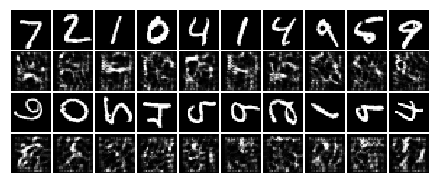

[4/500] D_loss: 0.8871, G_loss: 14.1970


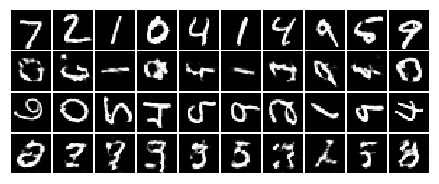

[8/500] D_loss: 0.9582, G_loss: 15.1085


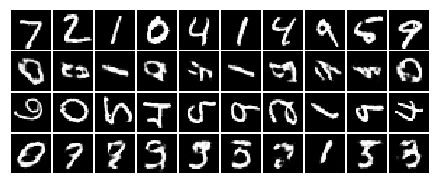

KeyboardInterrupt: 

In [42]:
# train model
sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epoch = 500
batch_size = 64

for epoch in range(n_epoch):
    np.random.shuffle(train_A)
    np.random.shuffle(train_B)
    for i in range(0, N, batch_size):
        batch_A = train_A[i:i+batch_size]
        batch_B = train_B[i:i+batch_size]
#         for k in range(5):
        _, G_loss_cur = sess.run([G_train_op, G_loss], {X_A: batch_A, X_B: batch_B, training: True})
        _, D_loss_cur = sess.run([D_train_op, D_loss], {X_A: batch_A, X_B: batch_B, training: True})

    if epoch % 4 == 0:
        # logging
        print('[{}/{}] D_loss: {:.4f}, G_loss: {:.4f}'.format(epoch, n_epoch, D_loss_cur, G_loss_cur))
            
        # plotting
        w = 10 # the number of test images
        samples_AB, samples_BA = sess.run([G_AB, G_BA], {X_A: test_A[:w], X_B: test_B[:w], training: False})
        samples = np.concatenate([test_A[:w], samples_AB, test_B[:w], samples_BA], axis=0)
        fig = plot(samples, shape=(4,w))
        plt.show()
        plt.close(fig)

[0/500] D_loss: 0.4709, G_loss: 7.2971


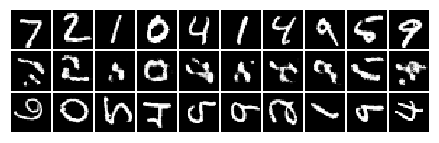

[1/500] D_loss: 0.6594, G_loss: 5.2649


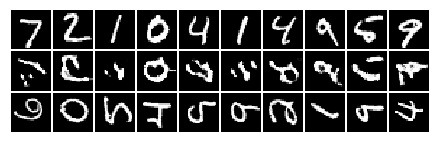

[2/500] D_loss: 0.5620, G_loss: 5.5460


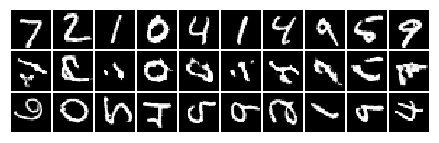

[3/500] D_loss: 0.5943, G_loss: 5.5388


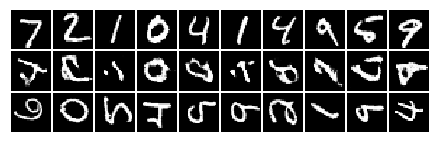

[4/500] D_loss: 0.6234, G_loss: 4.5762


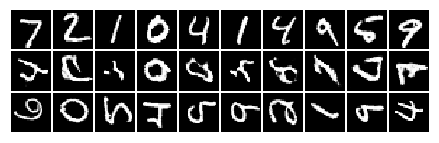

[5/500] D_loss: 0.4926, G_loss: 5.9260


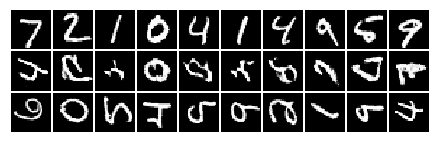

[6/500] D_loss: 0.4363, G_loss: 5.4777


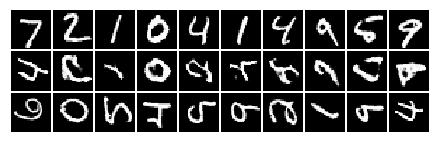

[7/500] D_loss: 0.4908, G_loss: 5.1854


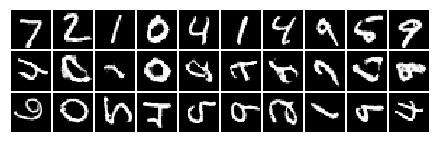

[8/500] D_loss: 0.4581, G_loss: 4.6980


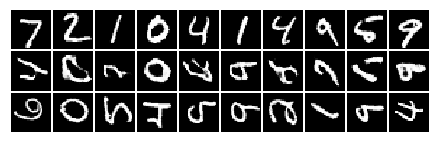

[9/500] D_loss: 0.4930, G_loss: 5.9733


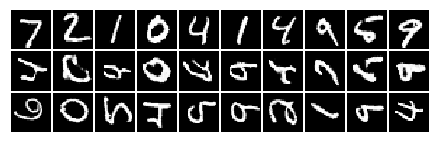

[10/500] D_loss: 0.8015, G_loss: 4.2986


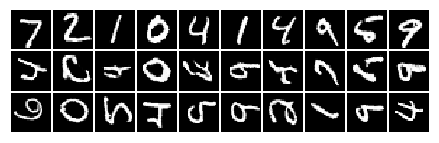

[11/500] D_loss: 0.4759, G_loss: 5.3955


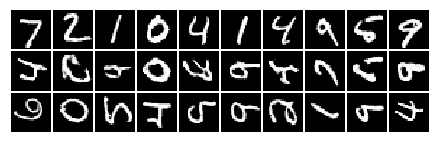

[12/500] D_loss: 0.4056, G_loss: 5.4994


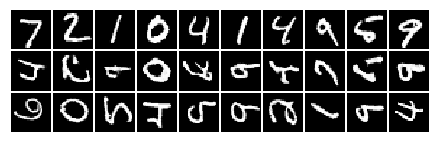

[13/500] D_loss: 0.5320, G_loss: 4.9148


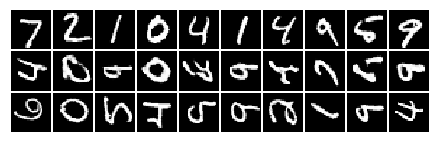

[14/500] D_loss: 0.5057, G_loss: 5.7886


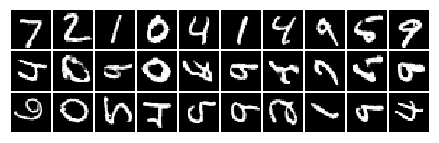

[15/500] D_loss: 0.7414, G_loss: 5.5562


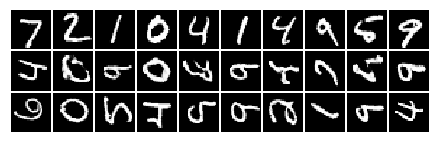

[16/500] D_loss: 0.7520, G_loss: 4.1182


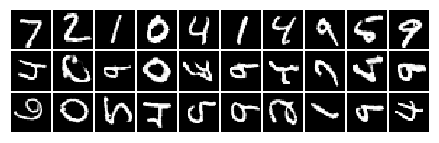

[17/500] D_loss: 0.6923, G_loss: 4.5483


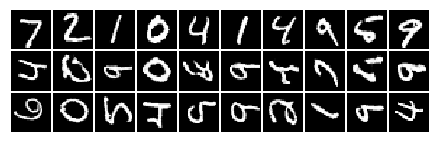

[18/500] D_loss: 0.6180, G_loss: 5.7510


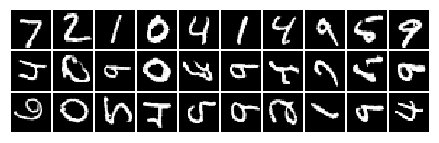

[19/500] D_loss: 0.7411, G_loss: 4.1384


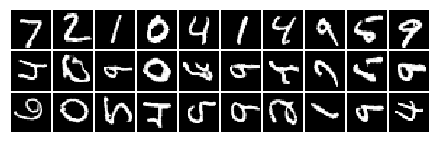

[20/500] D_loss: 0.5983, G_loss: 5.0687


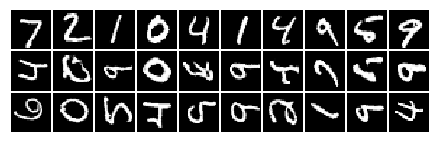

[21/500] D_loss: 0.6267, G_loss: 3.7428


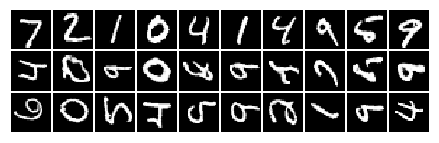

[22/500] D_loss: 0.5838, G_loss: 5.3173


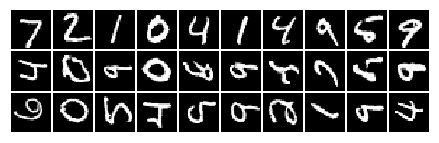

[23/500] D_loss: 0.6266, G_loss: 6.0480


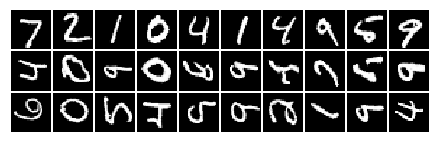

[24/500] D_loss: 0.6642, G_loss: 4.4438


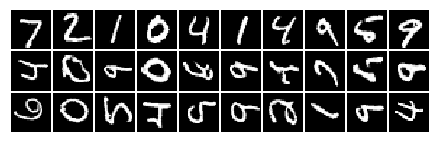

[25/500] D_loss: 0.6830, G_loss: 5.0409


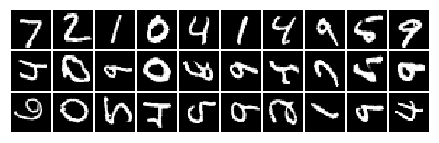

[26/500] D_loss: 0.4698, G_loss: 5.0521


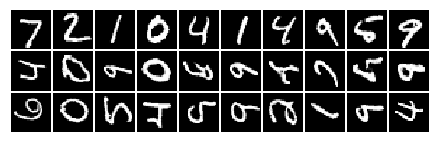

[27/500] D_loss: 0.6159, G_loss: 5.0454


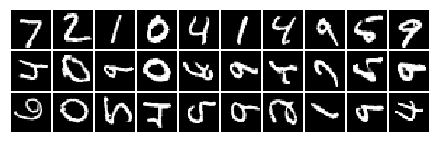

[28/500] D_loss: 0.8120, G_loss: 5.8089


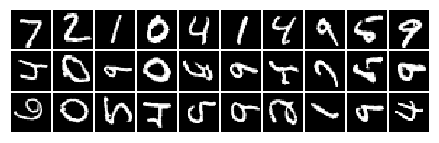

[29/500] D_loss: 0.5466, G_loss: 5.0383


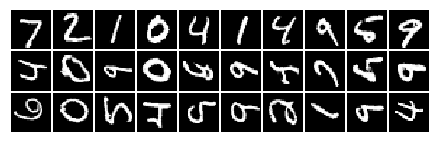

[30/500] D_loss: 0.5025, G_loss: 4.8309


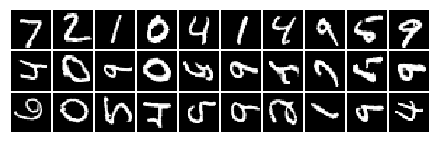

[31/500] D_loss: 0.4533, G_loss: 4.9963


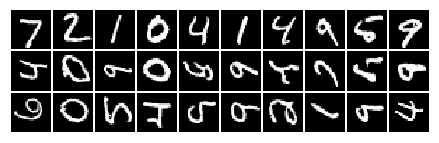

KeyboardInterrupt: 

In [30]:
# train model
sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epoch = 500
batch_size = 64

for epoch in range(n_epoch):
    np.random.shuffle(train_A)
    np.random.shuffle(train_B)
    for i in range(0, N, batch_size):
        batch_A = train_A[i:i+batch_size]
        batch_B = train_B[i:i+batch_size]
#         for k in range(5):
        _, G_loss_cur = sess.run([G_train_op, G_loss], {X_A: batch_A, X_B: batch_B, training: True})
        _, D_loss_cur = sess.run([D_train_op, D_loss], {X_A: batch_A, X_B: batch_B, training: True})

    if epoch % 1 == 0:
        # logging
        print('[{}/{}] D_loss: {:.4f}, G_loss: {:.4f}'.format(epoch, n_epoch, D_loss_cur, G_loss_cur))
            
        # plotting
        w = 10 # the number of test images
        samples_AB = sess.run(G_AB, {X_A: test_A[:w], X_B: test_B[:w], training: False})
        samples = np.concatenate([test_A[:w], samples_AB, test_B[:w]], axis=0)
        fig = plot(samples, shape=(3,w))
        plt.show()
        plt.close(fig)

In [ ]:
A = test_A[40:60]
B = test_B[40:60]
samples_AB, samples_BA = sess.run([G_AB, G_BA], {X_A: A, X_B: B})
samples = np.concatenate([A, samples_AB, B, samples_BA], axis=0)
fig = plot(samples, shape=(4,A.shape[0]))

In [ ]:
A = train_A[40:60]
B = train_B[40:60]
samples_AB, samples_BA = sess.run([G_AB, G_BA], {X_A: A, X_B: B})
samples = np.concatenate([A, samples_AB, B, samples_BA], axis=0)
fig = plot(samples, shape=(4,A.shape[0]))

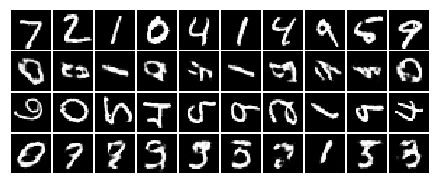

In [48]:
fig

In [49]:
samples.shape

(40, 784)

In [53]:
t = np.reshape(samples, [-1, 28, 28, 1])

In [54]:
np.reshape(t, [-1, 28*28]).shape

(40, 784)

In [56]:
a = t[:10]
b = t[10:20]

In [57]:
a.shape, b.shape

((10, 28, 28, 1), (10, 28, 28, 1))

In [59]:
ab = np.concatenate([a, b], axis=0)

In [60]:
ab.shape

(20, 28, 28, 1)

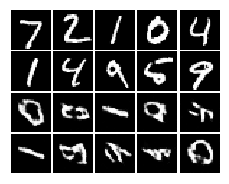

In [63]:
tmp = plot(ab, shape=(4,5))

In [65]:
ab.reshape(-1, 784).shape

(20, 784)

In [66]:
ab.shape

(20, 28, 28, 1)